In [1]:
from google.colab import drive
drive.mount('/content/drive/')
%cd drive/MyDrive/기계학습/팀프로젝트

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/기계학습/팀프로젝트


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score

player_stats_data = pd.read_csv('2010-2024_stat.csv')
player_contract_data = pd.read_csv('all_salary_data.csv',encoding='cp949')

In [3]:
#Position값들중 -가 있을경우 -앞의값을 사용
player_stats_data['Pos'] = player_stats_data['Pos'].str.split('-').str[0]
#Position값 정수값으로 변경
player_stats_data['Pos'] = player_stats_data['Pos'].map({'PG':0, 'SG':1, 'PF':2, 'SF':3, 'C':4})

In [4]:
player_contract_data.head()

,name,debut,start,end,salary,birth,target
0,A.J. Lawson,2021,2023,2026,1978006.0,2000,0.013971107
1,Aaron Brooks,2007,2015,2015,2250000.0,1985,0.032142857
2,Aaron Brooks,2007,2016,2016,2700000.0,1985,0.028679774
3,Aaron Brooks,2007,2017,2017,2116955.0,1985,0.021363315
4,Aaron Brooks,2007,2014,2014,1145685.0,1985,0.018166733


In [5]:
player_stats_data.head()

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,YEAR
0,A.J. Green,1.0,24,MIL,56,0,11,1.5,3.5,0.423,...,0.2,1,1.1,0.5,0.2,0.1,0.2,0.9,4.5,2024
1,A.J. Green,1.0,23,MIL,35,1,9.9,1.5,3.6,0.424,...,0.2,1.1,1.3,0.6,0.2,0,0.3,0.9,4.4,2023
2,A.J. Hammons,4.0,24,DAL,22,0,7.4,0.8,1.9,0.405,...,0.4,1.3,1.6,0.2,0,0.6,0.5,1,2.2,2017
3,A.J. Lawson,1.0,23,DAL,42,0,7.4,1.3,2.9,0.446,...,0.3,0.9,1.2,0.5,0.2,0.1,0.3,0.5,3.2,2024
4,A.J. Lawson,1.0,22,TOT,15,0,7.2,1.5,2.9,0.5,...,0.4,1,1.4,0.1,0.1,0,0.2,0.7,3.7,2023


<ipython-input-6-bb0ffd2ad785>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_contract_data['target'] = player_contract_data['target'].astype(float)
<ipython-input-6-bb0ffd2ad785>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_contract_data['quantile_norm_target'] = quantile_transformer.fit_transform(player_contract_data[['target']])


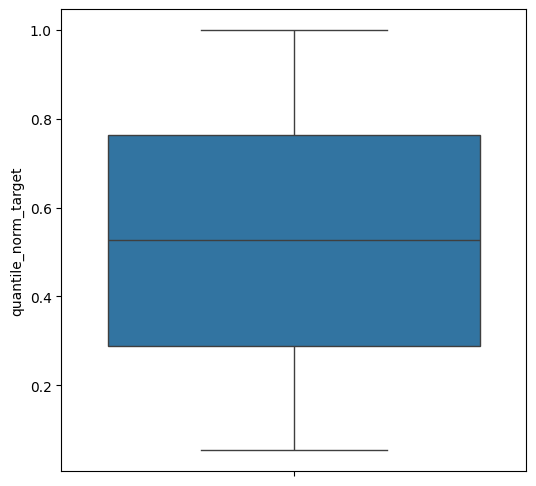

In [6]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import QuantileTransformer


player_contract_data = player_contract_data[player_contract_data['target'] != '#DIV/0!']
player_contract_data['target'] = player_contract_data['target'].astype(float)


quantile_transformer = QuantileTransformer(output_distribution='uniform')
player_contract_data['quantile_norm_target'] = quantile_transformer.fit_transform(player_contract_data[['target']])


lower_threshold = np.percentile(player_contract_data['quantile_norm_target'], 5)
player_contract_data = player_contract_data[player_contract_data['quantile_norm_target'] > lower_threshold]


fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
sns.boxplot(player_contract_data['quantile_norm_target'], ax=axes)
plt.show()

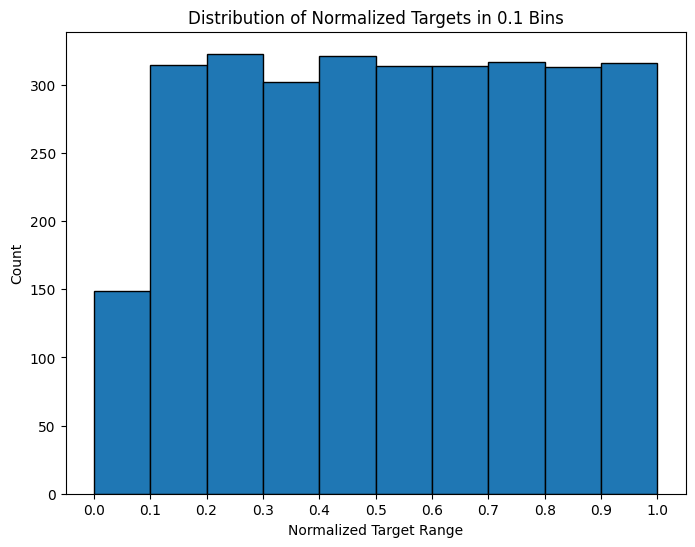

In [7]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import QuantileTransformer

# 0부터 1까지의 범위를 0.1 단위로 나누기
bins = np.arange(0, 1.1, 0.1)
hist, bin_edges = np.histogram(player_contract_data['quantile_norm_target'], bins=bins)

# 히스토그램 그리기
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(bin_edges[:-1], hist, width=0.1, align='edge', edgecolor='black')
ax.set_xticks(bins)
ax.set_xlabel('Normalized Target Range')
ax.set_ylabel('Count')
ax.set_title('Distribution of Normalized Targets in 0.1 Bins')

plt.show()


In [8]:
# 새로운 데이터셋 생성

player_stats_data = player_stats_data[player_stats_data['YEAR'] != 'YEAR']
player_stats_data['YEAR'] = player_stats_data['YEAR'].astype('int')
player_contract_data['start'] = player_contract_data['start'].astype('int')

year_range = 3

arr_average_stats = []
for _, row in player_contract_data.iterrows():
    player_name = row['name']
    start_year = row['start']
    target = row['target']

    filtered_stats = player_stats_data[(player_stats_data['Player'] == player_name) & (player_stats_data['YEAR'] > start_year - year_range) & (player_stats_data['YEAR'] <= start_year)]
    if not filtered_stats.empty:
        filtered_stats = filtered_stats.drop(columns=['Player', 'Pos', 'Age', 'Tm','YEAR'])
        filtered_stats = filtered_stats.astype(float)
        average_stats = filtered_stats.mean()

        # 선수 정보와 평균 스탯 결합
        result = {
            **average_stats.to_dict(),
            'target': target,
        }

        arr_average_stats.append(result)

average_stats_df = pd.DataFrame(arr_average_stats)
average_stats_df.head()


<ipython-input-8-a09e0234090c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_stats_data['YEAR'] = player_stats_data['YEAR'].astype('int')


,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,target
0,10.000000,0.000000,5.600000,1.333333,2.333333,0.662667,0.466667,1.166667,0.266667,0.866667,...,0.266667,1.000000,1.266667,0.066667,0.066667,0.000000,0.133333,0.800000,3.20,0.013971
1,47.428571,12.142857,19.328571,2.928571,7.100000,0.406143,1.100000,2.942857,0.368857,1.842857,...,0.400000,1.228571,1.642857,2.700000,0.600000,0.214286,1.471429,1.842857,8.00,0.032143
2,59.000000,9.000000,21.280000,3.380000,8.400000,0.404800,1.300000,3.400000,0.380400,2.120000,...,0.500000,1.400000,1.900000,3.220000,0.660000,0.160000,1.640000,2.080000,9.32,0.028680
3,72.000000,7.000000,17.633333,2.933333,7.133333,0.408333,1.066667,2.833333,0.373000,1.866667,...,0.333333,1.200000,1.533333,2.566667,0.500000,0.133333,1.366667,1.866667,7.90,0.021363
4,41.666667,10.666667,18.716667,2.716667,6.616667,0.403667,1.033333,2.800000,0.365833,1.700000,...,0.400000,1.166667,1.583333,2.616667,0.583333,0.216667,1.400000,1.766667,7.40,0.018167


In [9]:
train_X, test_X, train_y, test_y = train_test_split(average_stats_df.drop('target', axis=1), average_stats_df['target'], test_size=0.2, random_state=42)

# 모델 1
전체 변수를 사용하여 최적 하이퍼 파라미터를 찾고 best model 생성

In [10]:
pip install joblib

In [11]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
import os
import joblib

if(os.path.exists('./best_svr.pkl')):
    best_model = joblib.load('./best_svr.pkl')
else:
    param_grid = {
        'C': np.logspace(-4, 2, 10),
        'gamma': ['scale','auto'],
        'kernel': ['rbf','sigmoid'],
        'epsilon': np.logspace(-4, 2, 10),
        'degree': [2,3,4],
        'coef0': np.logspace(-4, 2, 10),
        'shrinking': [True, False]
    }


    grid_search = GridSearchCV(SVR(), param_grid, cv=5, scoring='r2', verbose=10, n_jobs=1)
    grid_search.fit(train_X, train_y)


    print(f"best hyperparameter: {grid_search.best_params_}")
    print(f"best R2 score: {grid_search.best_score_}")


    best_model = grid_search.best_estimator_
    test_predictions = best_model.predict(test_X)


    r2 = r2_score(test_y, test_predictions)

    print(f"Test R²: {r2}")

    joblib.dump(best_model, './best_svr.pkl')


In [12]:
test_predictions = best_model.predict(test_X)


r2 = r2_score(test_y, test_predictions)
mae = mean_absolute_error(test_y, test_predictions)
mse = mean_squared_error(test_y, test_predictions)
rmse = np.sqrt(mse)

print(f"Test R²: {r2}")

Test R²: 0.6191751210989604


# 모델 2
상관계수가 높은 10개의 변수를 사용하여 모델 생성

<ipython-input-17-f4fa700c88cd>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_correlations[best_feature], y=top_N_features, palette='viridis')


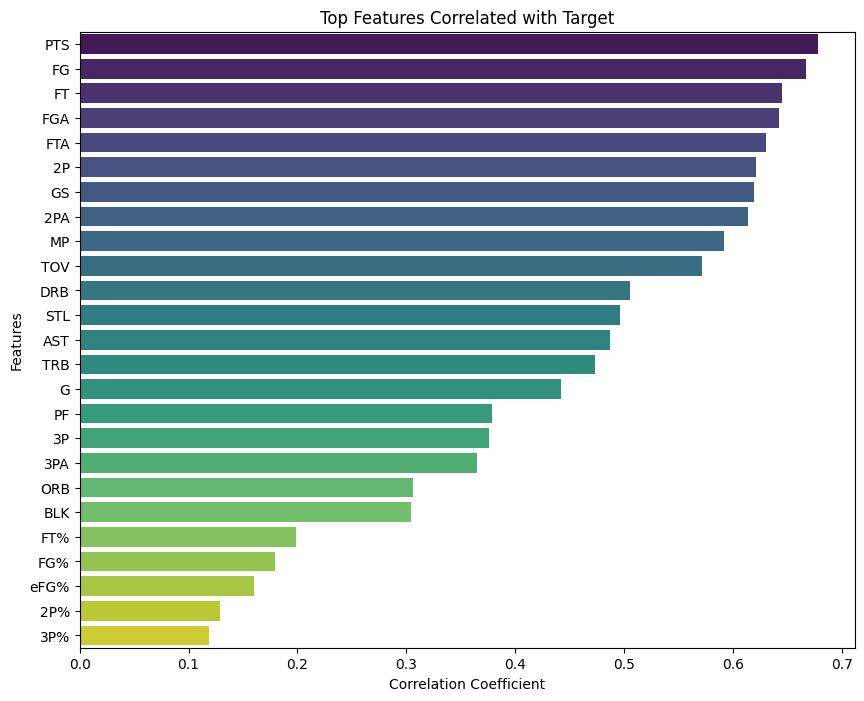

Top 25 R2 Score: 0.6191751210989399


In [17]:
# 상관계수 계산
correlation_matrix = average_stats_df.corr()

# 타겟 변수와의 상관계수 추출
target_correlations = correlation_matrix['target'].drop('target')  # 타겟 변수와 타겟 변수 간의 상관계수는 제외

# 상관계수의 절대값을 기준으로 내림차순 정렬
sorted_correlations = target_correlations.abs().sort_values(ascending=False)

best_r2_score = 0
best_N = 0
best_feature = None
target_length = len(target_correlations.tolist()) + 1
for N in range(1, target_length):
  top_N_features = sorted_correlations.head(N).index



  top_N_feature_data = average_stats_df[top_N_features]
  train_X, test_X, train_y, test_y = train_test_split(top_N_feature_data, average_stats_df['target'], test_size=0.2, random_state=42)

  best_model.fit(train_X, train_y)
  test_predictions = best_model.predict(test_X)


  r2 = r2_score(test_y, test_predictions)
  if r2 > best_r2_score:
    best_r2_score = r2
    best_N = N
    best_feature = top_N_features

plt.figure(figsize=(10, 8))
sns.barplot(x=sorted_correlations[best_feature], y=top_N_features, palette='viridis')
plt.title('Top Features Correlated with Target')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.show()
print(f"Top {best_N} R2 Score: {best_r2_score}")

# 모델 3
트리플 더블에 해당하는 6가지 변수를 사용하여 모델 생성

In [19]:
triple_double_columns = ['PTS', 'TRB', 'AST', 'STL', 'BLK']


triple_double_data = average_stats_df[triple_double_columns]

train_X, test_X, train_y, test_y = train_test_split(triple_double_data, average_stats_df['target'], test_size=0.2, random_state=42)

best_model.fit(train_X, train_y)
test_predictions = best_model.predict(test_X)


r2 = r2_score(test_y, test_predictions)
print(f"Triple Double R2 Score: {r2}")

Triple Double R2 Score: 0.5850820283360472


# 모델 4
평균을 내는 년도를 다양하게 모델을 만들어보자

In [20]:
best_year = 0
best_r2 = 0

for i in range(1, 10):
  year_range = i

  arr_average_stats = []
  for _, row in player_contract_data.iterrows():
      player_name = row['name']
      start_year = row['start']
      target = row['target']

      filtered_stats = player_stats_data[(player_stats_data['Player'] == player_name) & (player_stats_data['YEAR'] > start_year - year_range) & (player_stats_data['YEAR'] <= start_year)]
      if not filtered_stats.empty:
          filtered_stats = filtered_stats.drop(columns=['Player', 'Pos', 'Age', 'Tm','YEAR'])
          filtered_stats = filtered_stats.astype(float)
          average_stats = filtered_stats.mean()

          # 선수 정보와 평균 스탯 결합
          result = {
              **average_stats.to_dict(),
              'target': target,
          }

          arr_average_stats.append(result)

  i_average_stats_df = pd.DataFrame(arr_average_stats)

  train_X, test_X, train_y, test_y = train_test_split(i_average_stats_df.drop('target', axis=1), i_average_stats_df['target'], test_size=0.2, random_state=42)

  best_model.fit(train_X, train_y)
  test_predictions = best_model.predict(test_X)

  r2 = r2_score(test_y, test_predictions)

  if r2 > best_r2:
    best_r2 = r2
    best_year = i

print(f"Best Year Range: {best_year}")
print(f"Best R2 Score: {best_r2}")


Best Year Range: 2
Best R2 Score: 0.624060108002872
